In [1]:
# Imports
from google.colab import drive
drive.mount('/drive')

from typing import List, Literal

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

from itertools import chain

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

pd.set_option('display.max_columns', None)

Mounted at /drive


In [2]:
df_ests = pd.read_csv("../drive/MyDrive/data/Football/NFL_estimated_team_strengths_2022_2023.csv")
df_sched = pd.read_csv("../drive/MyDrive/data/Football/nfl_2023.csv")

In [3]:
df_ests.head()

,Team,Parameter Estimates,Standard Errors
0,Buffalo Bills,10.921761,2.787390
1,San Francisco 49ers,7.732556,2.712075
2,Cincinnati Bengals,6.931701,2.789975
3,Dallas Cowboys,6.489386,2.710889
4,Philadelphia Eagles,6.454176,2.710838


In [4]:
df_sched.head()

,Week,Day,Date,Time,Winner/tie,Unnamed: 5,Loser/tie,Unnamed: 7,PtsW,PtsL,YdsW,TOW,YdsL,TOL
0,1,Thu,2023-09-07,8:20PM,Detroit Lions,@,Kansas City Chiefs,boxscore,21,20,368,1,316,1
1,1,Sun,2023-09-10,1:00PM,Atlanta Falcons,NaN,Carolina Panthers,boxscore,24,10,221,0,281,3
2,1,Sun,2023-09-10,1:00PM,Cleveland Browns,NaN,Cincinnati Bengals,boxscore,24,3,350,2,142,0
3,1,Sun,2023-09-10,1:00PM,Jacksonville Jaguars,@,Indianapolis Colts,boxscore,31,21,342,2,280,3
4,1,Sun,2023-09-10,1:00PM,Washington Commanders,NaN,Arizona Cardinals,boxscore,20,16,248,3,210,2


In [5]:
df_sched['Week'].value_counts(dropna=False)

,count
Week,
Week,17
1,16
2,16
3,16
4,16
15,16
12,16
8,16
17,16


In [6]:
# Need to do research to find these (google, wikipedia, etc.)
# Of the format ('date of game', 'home team') - this is referring to the 'home team' in our data, not the actual home team since this is neutral...
neutral_games = {
    ('2023-10-01','Jacksonville Jaguars'),
    ('2023-10-08','Buffalo Bills'),
    ('2023-10-15', 'Tennessee Titans'),
    ('2023-11-05','Kansas City Chiefs'),
    ('2023-11-12','New England Patriots')
}

In [7]:
def schedule_preprocessing(df: pd.DataFrame, neutral_games_dict: dict) -> pd.DataFrame:
  # Remove useless rows
  df = df[df['Week'].notna() & (df['Week'] != 'Week')].copy()

  # Rename column for convenience
  df.rename(columns={'Unnamed: 5': 'home_identifier'}, inplace=True)

  # Assign Home and Away Teams
  df['home_team'] = np.where(df['home_identifier']=='@', df['Loser/tie'], df['Winner/tie'])
  df['away_team'] = np.where(df['home_identifier']=='@', df['Winner/tie'], df['Loser/tie'])

  # Convert points scored to integers
  df['PtsL'] = df['PtsL'].astype(int)
  df['PtsW'] = df['PtsW'].astype(int)

  # Obtain indices of rows for these particular games
  df['home_adv'] = ~df[['Date', 'home_team']].apply(tuple, axis=1).isin(neutral_games_dict)
  df['home_adv'] = df['home_adv'].astype(int)

  # Creating additional columns
  df['home_win'] = (df['home_identifier']!='@').astype(int)
  df['score_diff'] = np.where(df['home_win']==1,df['PtsW']-df['PtsL'],df['PtsL']-df['PtsW'])

  return df

In [8]:
df_prep = schedule_preprocessing(df=df_sched, neutral_games_dict=neutral_games)
df_prep.query('home_adv != 1')

,Week,Day,Date,Time,Winner/tie,home_identifier,Loser/tie,Unnamed: 7,PtsW,PtsL,YdsW,TOW,YdsL,TOL,home_team,away_team,home_adv,home_win,score_diff
52,4,Sun,2023-10-01,9:30AM,Jacksonville Jaguars,NaN,Atlanta Falcons,boxscore,23,7,300,0,287,3,Jacksonville Jaguars,Atlanta Falcons,0,1,16
69,5,Sun,2023-10-08,9:30AM,Jacksonville Jaguars,@,Buffalo Bills,boxscore,25,20,474,2,388,2,Buffalo Bills,Jacksonville Jaguars,0,0,-5
84,6,Sun,2023-10-15,9:30AM,Baltimore Ravens,@,Tennessee Titans,boxscore,24,16,360,1,233,2,Tennessee Titans,Baltimore Ravens,0,0,-8
131,9,Sun,2023-11-05,9:30AM,Kansas City Chiefs,NaN,Miami Dolphins,boxscore,21,14,267,1,292,1,Kansas City Chiefs,Miami Dolphins,0,1,7
146,10,Sun,2023-11-12,9:30AM,Indianapolis Colts,@,New England Patriots,boxscore,10,6,264,1,340,2,New England Patriots,Indianapolis Colts,0,0,-4


In [9]:
def create_X(df: pd.DataFrame) -> np.ndarray:
  """
  This function creates our design matrix with rows representing
  individual games and columns representing teams. For a given team in
  a given game, 1 means the team was home, -1 means the team is away,
  0 means the team is not playing.

  Parameters:
    df: Dataframe with match-level information

  Returns:
    Design matrix
  """

  # Dimensions of X
  n = len(df)
  p = df['home_team'].nunique()

  # Initialize with 0s
  X = np.zeros((n,p))

  # Sort teams
  team_sort = df['home_team'].sort_values().unique()

  # Assign 1s and -1s accordingly
  for i in range(len(X)):

    # Obtain team names for game i
    home_team = df['home_team'].iloc[i]
    away_team = df['away_team'].iloc[i]

    # Obtain corresponding indices
    home_idx = np.where(team_sort==home_team)[0][0]
    away_idx = np.where(team_sort==away_team)[0][0]

    # Assign values
    X[i,home_idx] = 1
    X[i,away_idx] = -1

  return X

def create_Xh(df: pd.DataFrame) -> np.ndarray:
  """
  This function creates our design matrix with rows representing
  individual games and columns representing teams. For a given team in
  a given game, 1 means the team was home, -1 means the team is away,
  0 means the team is not playing
  """
  X = create_X(df=df)

  # Add home-advantage column to design matrix - it will now be the final column
  X_h = np.column_stack((X, df['home_adv']))

  return X_h



In [10]:
X_h = create_Xh(df=df_prep)

In [11]:
X_h.shape

(285, 33)

In [12]:
X_h[:5,:5]

array([[ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0., -1.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [-1.,  0.,  0.,  0.,  0.]])

In [13]:
X_h[:5,-5:]

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 1.]])

In [14]:
teams_dict = {
    'AFC': {
        'AFC East': ['Buffalo Bills','Miami Dolphins', 'New York Jets', 'New England Patriots'],
        'AFC West': ['Kansas City Chiefs','Los Angeles Chargers','Denver Broncos','Las Vegas Raiders'],
        'AFC North': ['Baltimore Ravens','Pittsburgh Steelers','Cincinnati Bengals', 'Cleveland Browns'],
        'AFC South': ['Houston Texans','Indianapolis Colts', 'Jacksonville Jaguars','Tennessee Titans']
    },
    'NFC': {
        'NFC East': ['Dallas Cowboys','Philadelphia Eagles','New York Giants','Washington Commanders'],
        'NFC West': ['Arizona Cardinals','Los Angeles Rams','San Francisco 49ers','Seattle Seahawks'],
        'NFC North': ['Chicago Bears','Detroit Lions','Green Bay Packers','Minnesota Vikings'],
        'NFC South': ['Atlanta Falcons','Carolina Panthers','New Orleans Saints','Tampa Bay Buccaneers']
    }
}

In [15]:
def get_table(df: pd.DataFrame, teams_dict: dict, from_data: str = Literal["sched", "X"]) -> pd.DataFrame:
  """
  Produces final table (aka standings) by win percentage. Rankings are produced
  at the overall league level, the conference level and the division level.

  Args
    df: dataframe from which to obtain the final table. This can come in the form
    of a design matrix or by the original schedule data
    teams_dict: dictionary of NFL teams organized by conference and division
    from_data: string determining the origin of df. Either it's a design matrix, X,
    or it's the original schedule data.

  Returns
    Final table (aka standings)
  """
  # Depending on originating data, find df_W and df_L
  if from_data == "X":
    # Find number of wins and losses
    df_W = df['Winning_Team'].value_counts(dropna=False) \
    .reset_index() \
    .rename(columns={'Winning_Team':'Team', 'count':'W'})
    df_L = df['Losing_Team'].value_counts(dropna=False) \
    .reset_index() \
    .rename(columns={'Losing_Team':'Team', 'count':'L'})

  elif from_data == "sched":
    df_W = df['Winner/tie'].value_counts(dropna=False) \
    .reset_index() \
    .rename(columns={'Winner/tie':'Team', 'count':'W'})

    df_L = df['Loser/tie'].value_counts(dropna=False) \
    .reset_index() \
    .rename(columns={'Loser/tie':'Team', 'count':'L'})
  else:
    raise ValueError("from_data can only take 'sched' or 'X'!")

  # Join wins and losses
  df_table = df_W.merge(df_L, on='Team', how='outer')

  # Organize Teams
  afc = list(chain(*teams_dict['AFC'].values()))
  nfc = list(chain(*teams_dict['NFC'].values()))

  # Compute Win %
  df_table['W_Pct'] = df_table['W']/(df_table['W']+df_table['L'])

  # Compute Overall Rank
  df_table['NFL_Rank'] = df_table['W_Pct'].rank(ascending=False, method='min')

  # Compute Pct and Ranks
  df_table['Conf'] = np.where(df_table['Team'].isin(nfc), 'NFC','AFC')
  df_table['Conf_Rank'] = df_table.groupby('Conf')['W_Pct'].rank(ascending=False, method='min')

  divisions = [
    df_table['Team'].isin(teams_dict['AFC']['AFC East']),
    df_table['Team'].isin(teams_dict['AFC']['AFC West']),
    df_table['Team'].isin(teams_dict['AFC']['AFC North']),
    df_table['Team'].isin(teams_dict['AFC']['AFC South']),
    df_table['Team'].isin(teams_dict['NFC']['NFC East']),
    df_table['Team'].isin(teams_dict['NFC']['NFC West']),
    df_table['Team'].isin(teams_dict['NFC']['NFC North']),
    df_table['Team'].isin(teams_dict['NFC']['NFC South']),
  ]
  df_table['Div'] = np.select(
      divisions,
      ['AFC East','AFC West','AFC North','AFC South',
      'NFC East','NFC West','NFC North','NFC South'],
     default=None
      )

  df_table['Div_Rank'] = df_table.groupby('Div')['W_Pct'].rank(ascending=False, method='min')

  return df_table.sort_values(['Conf','Conf_Rank'], ascending=[True,True])


In [16]:
def get_param_ests(df: pd.DataFrame) -> np.ndarray:
  """
  Produces numpy array of team strength estimates and home field advantage estimate

  Args
    df: dataframe of previously estimated parameter estimates (generally from a prior season) and assumes home advantage parameter and estimated variance are two bottom rows

  Returns
    An array with parameter estimates
  """
  # Remove home advantage and variance for team sorting purposes
  df_tm = df.iloc[:-2,:].copy()
  df_tm.sort_values('Team', inplace=True)

  # Convert to array
  param_vec = np.array(df_tm['Parameter Estimates']).reshape((-1,1))

  # Stack home field advantage at the bottom
  param_vec = np.row_stack((param_vec, df.loc[df['Team']=='Home-Field Adv', 'Parameter Estimates'].values))

  return param_vec


## Simulation

### Option 1 - Simulate random error term
For the $i^{th}$ game of **next season** and the $s^{th}$ simulation,
$$ϵ_i^{(s)} \sim N(0, \sigma^{2}), \,\, \sigma^2 \text{ is estimated}$$

Then, add the random error term to the predicted values
$$y_i^{(s)} = \hat{y}_i + \epsilon_i^{(s)} = \mathbf{x}_i^\top\hat{\boldsymbol{\theta}}+ \epsilon_i^{(s)}$$

### Option 2 - Simulate the target (score differentials) directly
For the $i^{th}$ game of **next season** and the $s^{th}$ simulation,
$$y_i^{(s)} \sim N(\hat\theta_H-\hat\theta_A, \sigma^2), \,\, \sigma^2 \text{ is estimated}$$

### Option 3 - Introduce uncertainty into the estimated team strengths
For the $i^{th}$ game of **next season** and the $s^{th}$ simulation,
$$\boldsymbol{\theta}^{(s)} \sim N(\hat{\boldsymbol{\theta}}, se(\boldsymbol{\theta}))$$ $$y_i^{(s)} \sim N(\theta_H^{(s)}-\theta_A^{(s)}, \sigma^2), \,\, \sigma^2 \text{ is estimated}$$

### There are many other options too. We might update the coefficients after each game. Let's stick to the simple cases for now.

In [17]:
def run_sim(X: np.ndarray, df: pd.DataFrame, n_sim: int, teams_dict: dict) -> np.ndarray:
  """
  Produces random samples of score differentials

  Args
    X: design matrix containing all predictors
    df: dataframe of previously estimated parameter estimates (generally from a prior season)
    n_sim: number of seasons to simulate

  Returns
    Array of simulated score differentials. Each column is a full simulated season.

  Note
    This method of simulation assumes that the coefficients are fixed from beginning to end
    and from simulation to simulation. A more general approach would be to randomly
    sample the coefficients from their own distribution in each simulation and then
    keep those fixed over time. This is option 2 described above.
  """
  # Get team strenth and home advantage estimated coefficients
  param_ests = get_param_ests(df=df)

  # Estimate the mean score differential given game schedule and team strength + home field advantage estimates
  y_hat = X @ param_ests

  # Estimate the standard deviation of the random error
  std_dev_hat = df.loc[df['Team']=='Sigma', 'Parameter Estimates'].values

  # Generate random samples of target values
  n_games = len(X)
  y_sim = norm.rvs(loc=y_hat, scale=std_dev_hat, size=(n_games, n_sim))

  # Convert design matrix to dataframe
  nfc = list(chain(*teams_dict['NFC'].values()))
  afc = list(chain(*teams_dict['AFC'].values()))
  teams = sorted(nfc + afc)
  df_X = pd.DataFrame(X, columns=list(teams) + ['Home-Field Adv'])

  return y_sim, df_X


In [18]:
list(chain(*teams_dict['NFC'].values()))

['Dallas Cowboys',
 'Philadelphia Eagles',
 'New York Giants',
 'Washington Commanders',
 'Arizona Cardinals',
 'Los Angeles Rams',
 'San Francisco 49ers',
 'Seattle Seahawks',
 'Chicago Bears',
 'Detroit Lions',
 'Green Bay Packers',
 'Minnesota Vikings',
 'Atlanta Falcons',
 'Carolina Panthers',
 'New Orleans Saints',
 'Tampa Bay Buccaneers']

In [ ]:
y_sim, df_X = run_sim(X = X_h, df=df_ests, n_sim = 100, teams_dict=teams_dict)

In [ ]:
y_sim.shape, df_X.shape

((285, 100), (285, 33))

In [ ]:
y_sim[:4,:4]

array([[  0.30875498,   4.10189699,   4.02968893,  12.88509489],
       [  9.26193331, -12.51363215,   0.08280018,  -0.74503238],
       [ -3.25226777,   1.74235012,   1.33888973,  -8.34185342],
       [-19.36405226, -10.91196311, -26.15498387, -16.13008889]])

In [ ]:
df_X.head()

,Arizona Cardinals,Atlanta Falcons,Baltimore Ravens,Buffalo Bills,Carolina Panthers,Chicago Bears,Cincinnati Bengals,Cleveland Browns,Dallas Cowboys,Denver Broncos,Detroit Lions,Green Bay Packers,Houston Texans,Indianapolis Colts,Jacksonville Jaguars,Kansas City Chiefs,Las Vegas Raiders,Los Angeles Chargers,Los Angeles Rams,Miami Dolphins,Minnesota Vikings,New England Patriots,New Orleans Saints,New York Giants,New York Jets,Philadelphia Eagles,Pittsburgh Steelers,San Francisco 49ers,Seattle Seahawks,Tampa Bay Buccaneers,Tennessee Titans,Washington Commanders,Home-Field Adv
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [ ]:
def get_sim_results(df_X: pd.DataFrame, y_sim: np.ndarray, teams_dict: dict) -> pd.DataFrame:
  """
  Produces combined results with one table per simulation stacked on top of one
  another.

  Args
    df_X: design matrix containing all predictors
    y_sim: array of simulated score differentials. Each column is a full simulated season.
    teams_dict: dictionary of NFL teams organized by conference and division

  Returns
    Combined results
  """
  # Initialize final table dictionary
  table_dict = {}

  # Iterate through each simulation of next season
  for col in range(y_sim.shape[1]):
    # Create new design matrix for each simulated season
    df_res = df_X.copy()

    # Add column for simulated score differentials
    df_res['y_sim'] = y_sim[:,col]

    # Create column for easy computation
    df_res['Home_Team'] = df_X.iloc[:,:-1].eq(1).idxmax(axis=1)
    df_res['Away_Team'] = df_X.iloc[:,:-1].eq(-1).idxmax(axis=1)
    df_res['Home_Win'] = (df_res['y_sim']>0)*1
    df_res['Winning_Team'] = np.where(df_res['Home_Win']==1, df_res['Home_Team'], df_res['Away_Team'])
    df_res['Losing_Team'] = np.where(df_res['Home_Win']==1, df_res['Away_Team'], df_res['Home_Team'])

    # Get final table for simulated season
    df_table = get_table(df=df_res,teams_dict=teams_dict, from_data="X")
    df_table['sim_id'] = col

    # Collect simulation result
    table_dict[f"sim_{col}"] = df_table


  return pd.concat(table_dict.values(), ignore_index=True)



In [ ]:
df_sim = get_sim_results(df_X=df_X, y_sim=y_sim, teams_dict=teams_dict)

In [ ]:
df_sim.shape

(3200, 10)

In [ ]:
df_sim.tail()

,Team,W,L,W_Pct,NFL_Rank,Conf,Conf_Rank,Div,Div_Rank,sim_id
3195,Tampa Bay Buccaneers,7.0,12.0,0.368421,24.0,NFC,12.0,NFC South,4.0,99
3196,New York Giants,6.0,11.0,0.352941,25.0,NFC,13.0,NFC East,4.0,99
3197,Minnesota Vikings,5.0,12.0,0.294118,28.0,NFC,14.0,NFC North,4.0,99
3198,Los Angeles Rams,5.0,13.0,0.277778,30.0,NFC,15.0,NFC West,3.0,99
3199,Arizona Cardinals,4.0,13.0,0.235294,31.0,NFC,16.0,NFC West,4.0,99


## Who makes the playoffs?
- 7 teams from both the NFC and AFC make the playoffs
- The top team in each conference receives a first round bye (automatically advancing to the second round)
- The 4 division champions from each conference are seeded 1 through 4 based on their win-loss-tie record.
- 3 wild card qualifiers from each conference (the 3 teams with the best overall recorded of the remaining teams in the conference) are seeded 5, 6, and 7
- If teams are tied having the same regular season win-loss-tie record, the seeding is determined by tie-breaking rules: https://en.wikipedia.org/wiki/NFL_playoffs#Breaking_ties
  - There are a lot of rules here...
  - Ideally, we would build in the logic to all of them, but this may be impractical.


## Results from Simulation


In [ ]:
!pip install joypy
import joypy

In [ ]:
# Obtain from LLM (in alphabetical order)
nfl_colors = [
    "#97233F", "#A71930", "#241773", "#00338D", "#0085CA",
    "#0B162A", "#FB4F14", "#311D00", "#003594", "#FB4F14",
    "#0076B6", "#203731", "#03202F", "#002C5F", "#006778",
    "#E31837", "#000000", "#0080C6", "#003594", "#008E97",
    "#4F2683", "#002244", "#D3BC8D", "#0B2265", "#125740",
    "#004C54", "#000000", "#AA0000", "#002244", "#D50A0A",
    "#0C2340", "#5A1414"
]

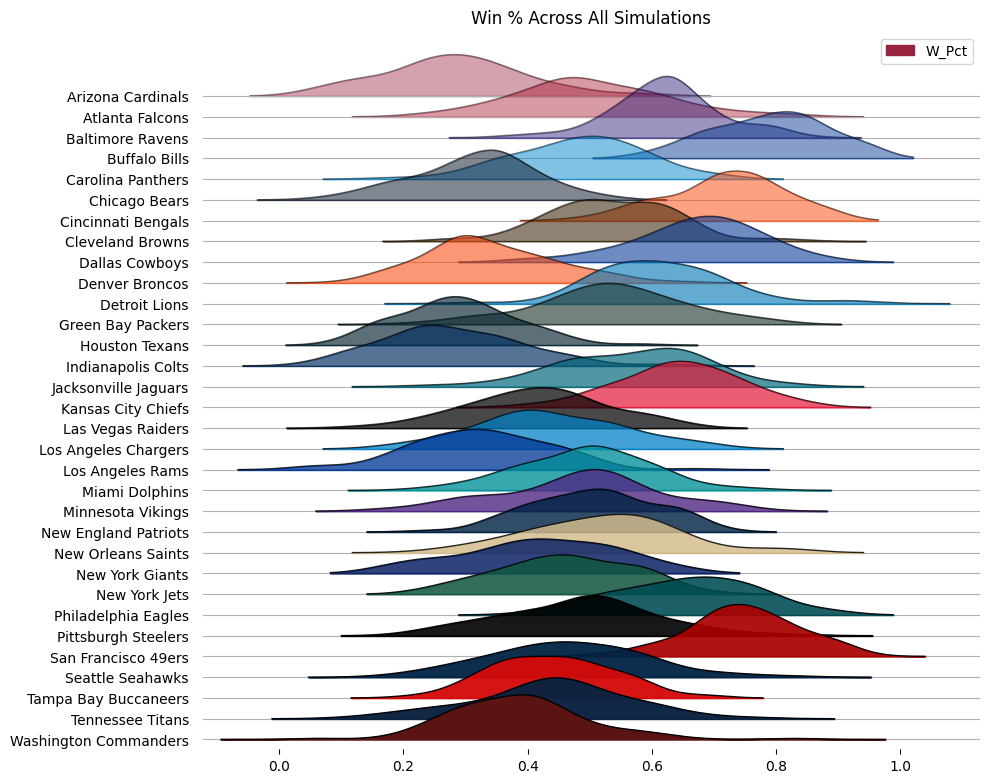

In [ ]:
fig, axes = joypy.joyplot(df_sim, by="Team", column="W_Pct", range_style='own',
                          grid="y", linewidth=1, legend=True, figsize=(10,8), fade=True,
                          title="Win % Across All Simulations",
                          color=nfl_colors)

### Proportion of \#1 Ranks By Team

In [ ]:
df_sim_means = df_sim.groupby(['Team','Conf'])[['W','L','W_Pct','NFL_Rank','Conf_Rank', 'Div_Rank']] \
.agg('mean') \
.reset_index() \
.sort_values(['W_Pct'], ascending=False)

In [ ]:
df_sim_means

,Team,Conf,W,L,W_Pct,NFL_Rank,Conf_Rank,Div_Rank
3,Buffalo Bills,AFC,15.240000,3.836735,0.798067,2.571429,1.714286,1.102041
27,San Francisco 49ers,NFC,14.440000,5.560000,0.722000,4.440000,2.330000,1.030000
6,Cincinnati Bengals,AFC,11.940000,5.111111,0.699346,5.262626,3.060606,1.484848
8,Dallas Cowboys,NFC,12.230000,5.770000,0.679444,6.170000,3.040000,1.440000
15,Kansas City Chiefs,AFC,13.830000,7.170000,0.658571,6.840000,3.870000,1.140000
25,Philadelphia Eagles,NFC,11.750000,6.250000,0.652778,7.770000,3.950000,1.740000
2,Baltimore Ravens,AFC,12.050000,6.950000,0.634211,8.950000,5.070000,2.080000
10,Detroit Lions,NFC,11.990000,8.010000,0.599500,9.990000,4.950000,1.480000
14,Jacksonville Jaguars,AFC,9.890000,7.110000,0.581765,10.620000,5.870000,1.200000
22,New Orleans Saints,NFC,9.150000,7.850000,0.538235,12.940000,6.570000,1.980000


In [ ]:
nfl_rank1 = df_sim[df_sim['NFL_Rank']==1]['Team'].value_counts(dropna=False).reset_index().rename(columns={'count':'NFL Rank 1'})
nfl_rank1['NFL Rank 1 Prob'] = nfl_rank1['NFL Rank 1']/100
conf_rank1 = df_sim[df_sim['Conf_Rank']==1]['Team'].value_counts(dropna=False).reset_index().rename(columns={'count':'Conf Rank 1'})
conf_rank1['Conf Rank 1 Prob'] = conf_rank1['Conf Rank 1']/100
div_rank1 = df_sim[df_sim['Div_Rank']==1]['Team'].value_counts(dropna=False).reset_index().rename(columns={'count':'Div Rank 1'})
div_rank1['Div Rank 1 Prob'] = div_rank1['Div Rank 1']/100


In [ ]:
df_sim_means = df_sim_means.merge(nfl_rank1[['Team','NFL Rank 1 Prob']], how='left', on='Team')
df_sim_means = df_sim_means.merge(conf_rank1[['Team','Conf Rank 1 Prob']], how='left', on='Team')
df_sim_means = df_sim_means.merge(div_rank1[['Team','Div Rank 1 Prob']], how='left', on='Team')

df_sim_means.fillna(0, inplace=True)

In [ ]:
playoff_conditions = [
    df_sim['Div_Rank']==1,
    (df_sim['Div_Rank']!=1) & (df_sim['Conf_Rank'] <= 7)
    ]
df_sim['make_playoffs'] = np.select(playoff_conditions, [1,1], default=0)

In [ ]:
df_sim_means = df_sim_means.merge(df_sim.groupby('Team')['make_playoffs'].agg('mean').reset_index().rename(columns={'make_playoffs': 'Playoff %'}), on='Team', how='left')

In [ ]:
nfl_colors_dict = dict(zip(df_sim['Team'].sort_values().unique(), nfl_colors))

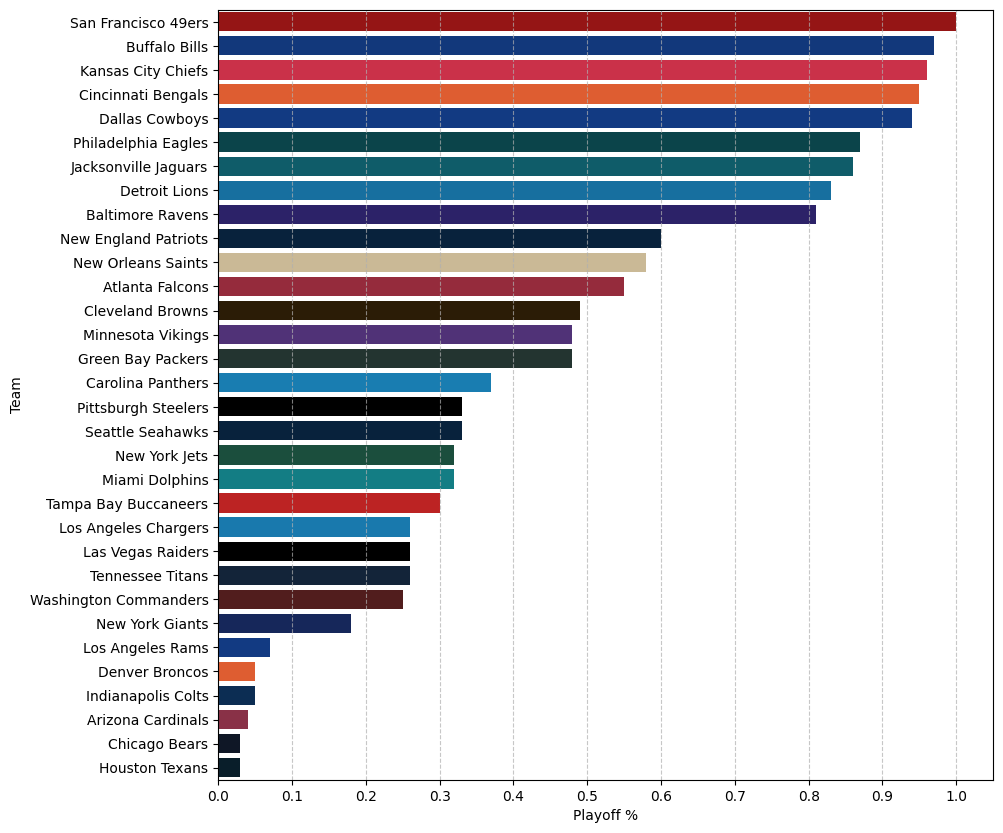

In [ ]:
plt.figure(figsize=(10,10))
sns.barplot(x='Playoff %',y='Team', hue='Team', data=df_sim_means.sort_values('Playoff %', ascending=False), orient='h', palette=nfl_colors_dict)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.grid(axis='x', linestyle='--', alpha=0.7)

In [ ]:
df_actual_table = get_table(df=df_prep, teams_dict=teams_dict, from_data="sched")
df_actual_table.rename(columns={'W':'W Actual', 'W_Pct':'W_Pct Actual'}, inplace=True)
df_final_table = df_sim_means.merge(df_actual_table[['Team','W Actual','W_Pct Actual']], how='left', on='Team')

In [ ]:
df_final_table['W Error'] = df_final_table['W Actual']-df_final_table['W']
df_final_table['W_Pct Error'] = df_final_table['W_Pct Actual']-df_final_table['W_Pct']
df_final_table['Abs W Error'] = np.abs(df_final_table['W Error'])


In [ ]:
df_final_table.sort_values(['W_Pct'], ascending=False)

,Team,Conf,W,L,W_Pct,NFL_Rank,Conf_Rank,Div_Rank,NFL Rank 1 Prob,Conf Rank 1 Prob,Div Rank 1 Prob,Playoff %,W Actual,W_Pct Actual,W Error,W_Pct Error,Abs W Error
0,Buffalo Bills,AFC,15.240000,3.836735,0.798067,2.571429,1.714286,1.102041,0.44,0.59,0.93,0.97,12,0.631579,-3.240000,-0.166488,3.240000
1,San Francisco 49ers,NFC,14.440000,5.560000,0.722000,4.440000,2.330000,1.030000,0.12,0.33,0.97,1.00,14,0.700000,-0.440000,-0.022000,0.440000
2,Cincinnati Bengals,AFC,11.940000,5.111111,0.699346,5.262626,3.060606,1.484848,0.09,0.22,0.63,0.95,9,0.529412,-2.940000,-0.169935,2.940000
3,Dallas Cowboys,NFC,12.230000,5.770000,0.679444,6.170000,3.040000,1.440000,0.11,0.30,0.61,0.94,12,0.666667,-0.230000,-0.012778,0.230000
4,Kansas City Chiefs,AFC,13.830000,7.170000,0.658571,6.840000,3.870000,1.140000,0.07,0.11,0.90,0.96,15,0.714286,1.170000,0.055714,1.170000
5,Philadelphia Eagles,NFC,11.750000,6.250000,0.652778,7.770000,3.950000,1.740000,0.09,0.21,0.44,0.87,11,0.611111,-0.750000,-0.041667,0.750000
6,Baltimore Ravens,AFC,12.050000,6.950000,0.634211,8.950000,5.070000,2.080000,0.04,0.06,0.28,0.81,14,0.736842,1.950000,0.102632,1.950000
7,Detroit Lions,NFC,11.990000,8.010000,0.599500,9.990000,4.950000,1.480000,0.01,0.05,0.64,0.83,14,0.700000,2.010000,0.100500,2.010000
8,Jacksonville Jaguars,AFC,9.890000,7.110000,0.581765,10.620000,5.870000,1.200000,0.02,0.03,0.81,0.86,9,0.529412,-0.890000,-0.052353,0.890000
9,New Orleans Saints,NFC,9.150000,7.850000,0.538235,12.940000,6.570000,1.980000,0.00,0.05,0.42,0.58,9,0.529412,-0.150000,-0.008824,0.150000


In [ ]:
df_final_table.sort_values(['Abs W Error'], ascending=True)

,Team,Conf,W,L,W_Pct,NFL_Rank,Conf_Rank,Div_Rank,NFL Rank 1 Prob,Conf Rank 1 Prob,Div Rank 1 Prob,Playoff %,W Actual,W_Pct Actual,W Error,W_Pct Error,Abs W Error
11,New Orleans Saints,NFC,8.88,8.120000,0.522353,13.870000,7.030000,1.99000,0.00,0.02,0.45,0.58,9,0.529412,0.12,0.007059,0.12
3,Dallas Cowboys,NFC,12.13,5.870000,0.673889,6.400000,3.350000,1.49000,0.07,0.21,0.58,0.92,12,0.666667,-0.13,-0.007222,0.13
10,Green Bay Packers,NFC,10.13,8.870000,0.533158,13.860000,7.030000,2.10000,0.01,0.04,0.26,0.56,10,0.526316,-0.13,-0.006842,0.13
8,Jacksonville Jaguars,AFC,9.70,7.300000,0.570588,11.290000,6.050000,1.26000,0.01,0.05,0.82,0.83,9,0.529412,-0.70,-0.041176,0.70
30,Arizona Cardinals,NFC,4.77,12.230000,0.280588,26.910000,13.670000,3.45000,0.00,0.00,0.00,0.03,4,0.235294,-0.77,-0.045294,0.77
19,New York Jets,AFC,7.85,9.150000,0.461765,17.530000,9.270000,3.12000,0.00,0.00,0.00,0.34,7,0.411765,-0.85,-0.050000,0.85
4,Philadelphia Eagles,NFC,11.90,6.161616,0.657688,7.191919,3.717172,1.59596,0.09,0.22,0.55,0.90,11,0.611111,-0.90,-0.046577,0.90
24,Las Vegas Raiders,AFC,7.06,9.940000,0.415294,19.950000,10.350000,2.62000,0.00,0.00,0.06,0.20,8,0.470588,0.94,0.055294,0.94
1,San Francisco 49ers,NFC,14.97,5.030000,0.748500,3.810000,2.060000,1.03000,0.24,0.44,0.97,1.00,14,0.700000,-0.97,-0.048500,0.97
18,Seattle Seahawks,NFC,7.89,9.110000,0.464118,17.470000,8.850000,2.33000,0.00,0.01,0.02,0.40,9,0.529412,1.11,0.065294,1.11


<Axes: xlabel='W Actual', ylabel='W Error'>

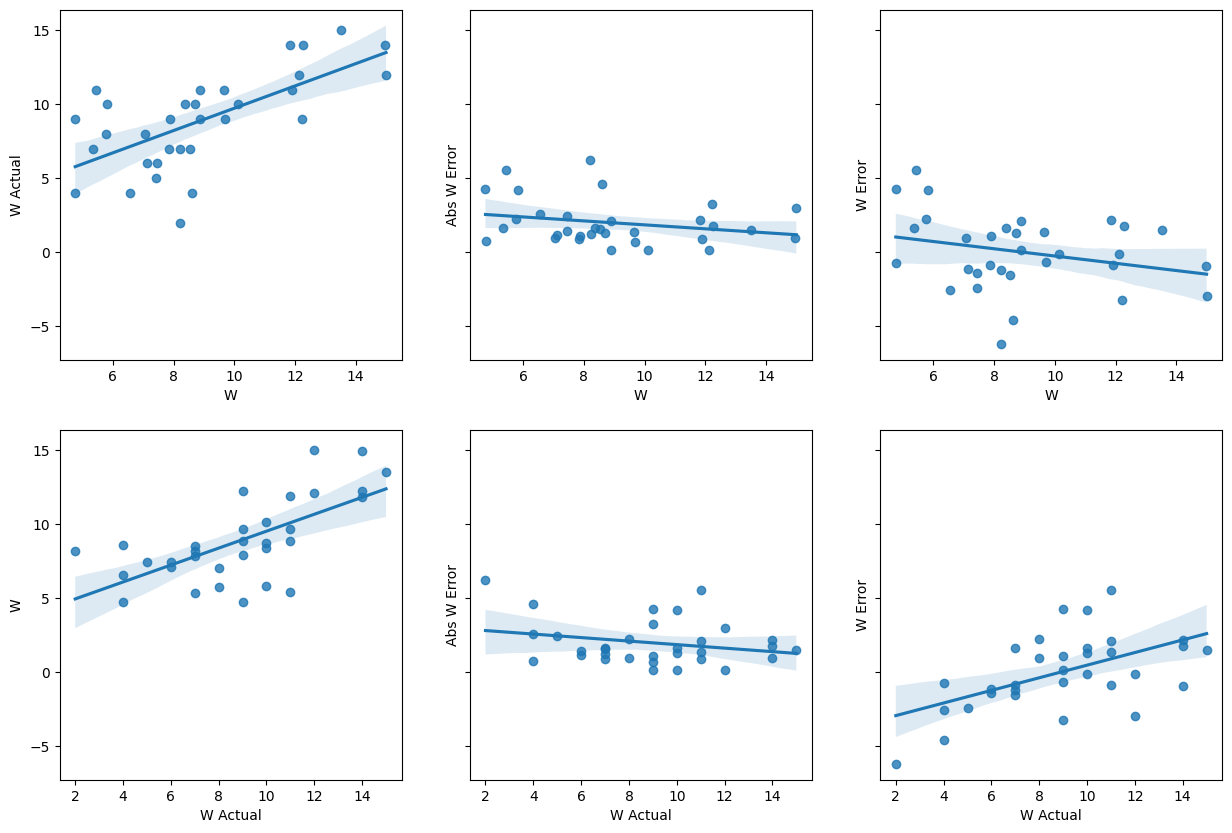

In [ ]:
fig, axs = plt.subplots(2,3,figsize=(15,10), sharey=True)
sns.regplot(x='W',y='W Actual', data=df_final_table, ax=axs[0,0])
sns.regplot(x='W',y='Abs W Error', data=df_final_table, ax=axs[0,1])
sns.regplot(x='W',y='W Error', data=df_final_table, ax=axs[0,2])
sns.regplot(x='W Actual',y='W', data=df_final_table, ax=axs[1,0])
sns.regplot(x='W Actual',y='Abs W Error', data=df_final_table, ax=axs[1,1])
sns.regplot(x='W Actual',y='W Error', data=df_final_table, ax=axs[1,2])
